In [1]:
import torch
from src.k_tree import Ktree
from src.k_tree_ls import Ktree as Ktree_ls
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc
import numpy as np
from polygenerator import random_polygon
import matplotlib.pyplot as plt
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Data generated


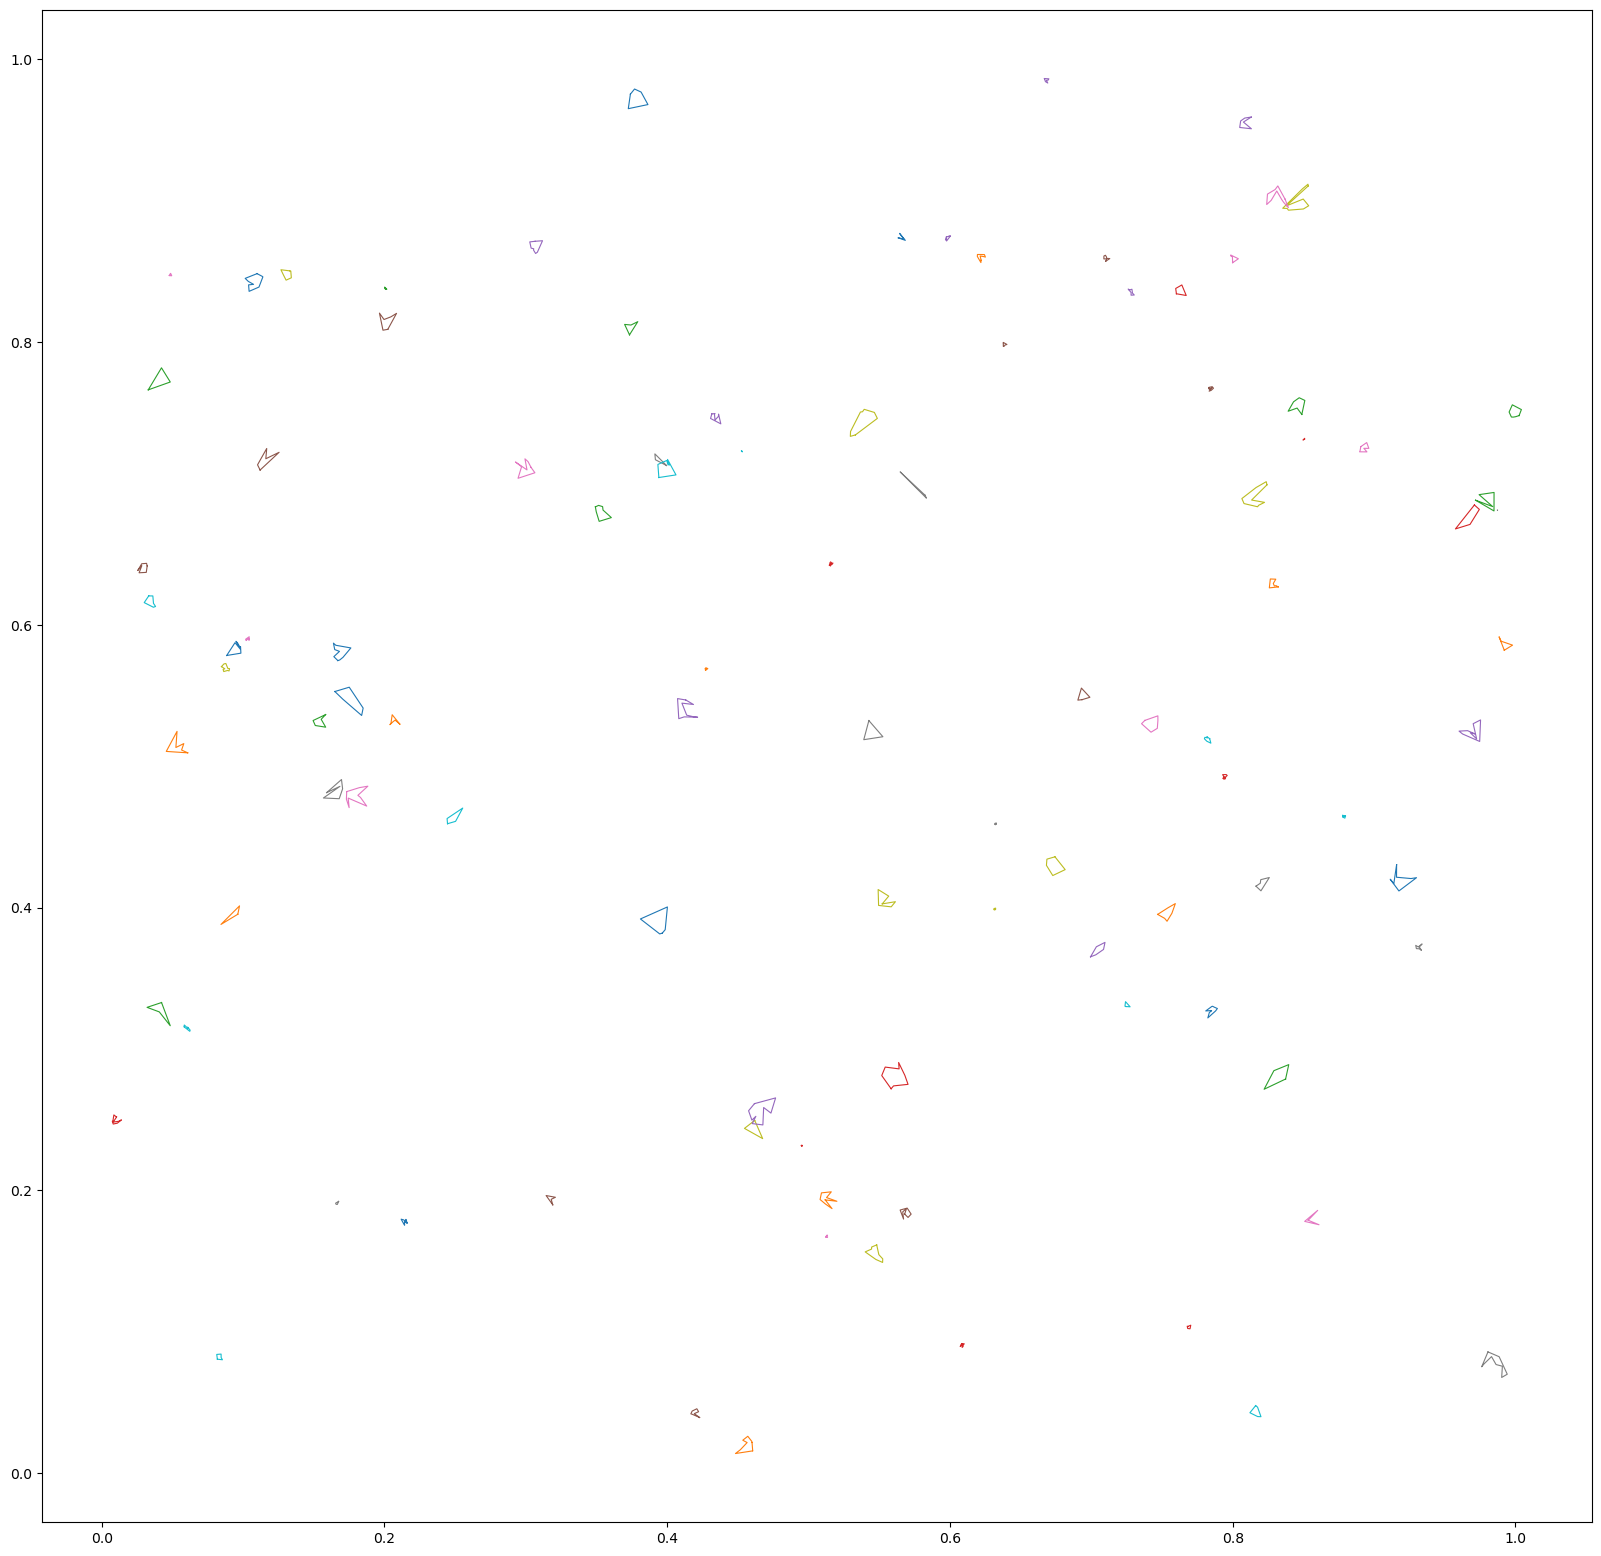

In [2]:
# lets geenrate N random polygons with <= n vertices
bbox_lim = 1e5
bbox = [0, bbox_lim, 0, bbox_lim]
norm = bbox[-1]
# N = 1000
N = 100
n = 10

scale_max = int(0.02 * bbox_lim)
scale_min = 1
# make a vertice list values that are between 3 and n (size=(N, 1))
torch.manual_seed(42)
n_list = torch.randint(3, n + 1, (1, N)).squeeze()
polygons = [torch.tensor(random_polygon(num_points=n_list[i].item())) for i in range(N)]
# lets scale and translate them
# translate is in 2 axis x  and y

x_t = bbox[0], bbox[1]
y_t = bbox[2], bbox[3]
for i in range(N):
    polygon = polygons[i]
    # scale
    scale = torch.rand(1) * (scale_max - scale_min) + scale_min
    polygon = polygon * scale
    # translate
    polygon = polygon + torch.tensor([random.uniform(*x_t), random.uniform(*y_t)])
    polygons[i] = polygon / norm

# print(polygons)


# normalize them first to 0,1 global bbox
# plot them
def plot_polygon(polygon, out_file_name=None):
    # for i, (x, y) in enumerate(polygon):
    # plt.text(x, y, str(i), horizontalalignment="center", verticalalignment="center")

    # just so that it is plotted as closed polygon
    # polygon.append(polygon[0])
    polygon = torch.cat((polygon, polygon[0].reshape(1, 2)))
    xs, ys = zip(*polygon)
    plt.plot(xs, ys, linewidth=0.8)
    # make axis equal
    plt.gca().set_aspect("equal", adjustable="box")

    if out_file_name is not None:
        plt.savefig(out_file_name, dpi=300)


print("Data generated")

plt.figure(figsize=(20, 20))
for i, polygon in enumerate(polygons):
    plot_polygon(polygon)
plt.show()

polygons_new = [
    torch.cat(
        (
            polygon,
            torch.tensor([[float("inf"), float("inf")]] * (n - n_list[i].item())),
        )
    )
    for i, polygon in enumerate(polygons)
]
# make it tensor
data = torch.stack(polygons_new)
# print(data)

In [69]:
import torch
from src.k_tree_poly import Ktree as Ktree_pls
from src.utils.objects.squares import loadData as loadSquares
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# lets generate #n line segments inside a bbox
# n = 100
# bbox = [0, 1000, 0, 1000]  # bbox
# length_size = [0.1, 100]  # length of the line segment
# theta_size = [0, 180]  # angle of the line segment


# # line segments will be [x0,y0,l,theta]
# # sample x0,y0 inside bbox
# def create_line_segments(n, bbox, length_size, theta_size):
#     print(f"Creating {n} line segments")
#     x0 = torch.rand(n) * (bbox[1] - bbox[0]) + bbox[0]
#     y0 = torch.rand(n) * (bbox[3] - bbox[2]) + bbox[2]
#     print(f"x0 shape: {x0.shape}")
#     # sample l inside length_size
#     l = torch.rand(n) * (length_size[1] - length_size[0]) + length_size[0]
#     print(f"l shape: {l.shape}")
#     # sample theta inside theta_size
#     theta_size = torch.rand(n) * (theta_size[1] - theta_size[0]) + theta_size[0]
#     print(f"theta shape: {theta_size.shape}")
#     theta_size = torch.deg2rad(theta_size)
#     return torch.stack([x0, y0, l, theta_size], dim=1)


# data = create_line_segments(n, bbox, length_size, theta_size)
# print(f"Data shape: {data.shape}")
# # first make data from embedding to datapoints
# data_points = torch.zeros(n, 4)
# data_points[:, 0] = data[:, 0]
# data_points[:, 1] = data[:, 1]
# data_points[:, 2] = data[:, 0] + data[:, 2] * torch.cos(data[:, 3])
# data_points[:, 3] = data[:, 1] + data[:, 2] * torch.sin(data[:, 3])
# print(f"Data points shape: {data_points.shape}")
# data2d = data

dim = 2  # space dimension

k = 3  # number of centroids to generate in the Clustering model
clustering_args = {
    "epochs": 5,  # number of epochs
    "pre_processing": 5,
    "number_of_centroids": k,  # number of centroids to generate in the Clustering model
    "dimension": dim,  # space dimension
}
# n = 50
n = 30
un_args = {
    "N": n,  # number of points to sample
    "M": n**2 - 1,  # number of points to return
    "epsilon": 0.2,  # the epsilon ball. Increase this to get more points (as var increases)
    # .15
}
critic_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 2000,  # number of epochs
    "width": 300,  # width of the model's linear layers
    "depth": 5,  # depth of the model's linear layers
}

threshold = 3 * k  # if a tree node has data less than the threshold, stop division
# threshold = 998
# threshold = 98

# Initialise the k-tree structure.
from src.metrics import point_to_polygon_distance

# pass data to the k-tree
distance_function = point_to_polygon_distance
ktree = Ktree_pls(
    threshold,
    data,
    distance_function,
    clustering_args,
    un_args,
    critic_args,
    device,
    dim,
)
# pass data to device
data = data.to(device)
print("Starting to create the tree...")
print("=" * 20)
ktree.create_tree(save_path_prefix="./models/line_segments/2d/5k/", plot=False)

Starting to create the tree...

Creating critic for node 0 that has 100 data, which is more than the threshold 9.
Bounding box for node 0: [[0.0074565778486430645, 1.0041992664337158], [0.01382373459637165, 0.9864198565483093]]
Creating clustering for node 0 with 3 centroids.
Initial divergence: 28.377933502197266
Starting iteration 1
Centroids:  tensor([[0.3064, 0.8672],
        [0.0601, 0.3149],
        [0.7282, 0.8354]], device='cuda:0')
Iteration 1, divergence: 28.377933502197266
Starting iteration 2
Centroids:  tensor([[0.2923, 0.7523],
        [0.2732, 0.3372],
        [0.7726, 0.5993]], device='cuda:0')
Iteration 2, divergence: 22.837594985961914
Starting iteration 3
Centroids:  tensor([[0.2706, 0.7087],
        [0.3285, 0.2746],
        [0.7949, 0.5941]], device='cuda:0')
Iteration 3, divergence: 22.15992546081543
Starting iteration 4
Centroids:  tensor([[0.2512, 0.6744],
        [0.4032, 0.2029],
        [0.7951, 0.6142]], device='cuda:0')
Iteration 4, divergence: 21.434867858

In [70]:
print(f"Tree node number is {ktree.number_of_nodes}")

leaves = ktree.get_leaves()

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)

Tree node number is 31
Tree height is 4.
Created 21 leaves with sizes
[7, 2, 6, 8, 2, 7, 1, 4, 6, 3, 5, 4, 1, 9, 8, 3, 5, 8, 6, 3, 2]


In [73]:
import numpy as np

acc.random_queries(ktree, n=100, times=1, k=1)

The number of queries per layer are:
[100.  98.  79.]
The percentage of correct predictions per layer is:
[98. 98. 96.]
The mean percentage of correct predictions per layer is:
[98. 98. 96.]


In [78]:
sum(flags)

212

In [79]:
# lets do random querries
n = 100
torch.manual_seed(42)
random_queries = torch.rand(n, 2).to(device)

accuracy = 0
flags = []
for query in random_queries:
    pred = ktree.query_verbose(query)["nn"][0]
    ground_truth = ktree.root.query(query)[0]
    dist_pred = distance_function(pred, query)
    dist_gt = distance_function(ground_truth, query)
    if torch.equal(pred, ground_truth):
        flag = True
    elif dist_pred == dist_gt:
        print("=" * 20)
        print(f"pred: {pred}")
        print(f"ground truth: {ground_truth}")
        print(f"Query: {query}")
        print(f"Predicted: {dist_pred}")
        print(f"Ground truth: {dist_gt}")
        flag = True
    else:
        print("=" * 20)
        print("Wrong prediction")
        print("=" * 20)
        print(f"Query: {query}")
        print(f"Predicted: {pred}")
        print(f"Ground truth: {ground_truth}")
        print(f"Predicted distance: {dist_pred}")
        print(f"Ground truth distance: {dist_gt}")
        flag = False
    if flag is True:
        accuracy += 1
    flags.append(flag)


print(f"Accuracy is {accuracy/n}")

Wrong prediction
Query: tensor([0.3829, 0.9593], device='cuda:0')
Predicted: tensor([[0.3733, 0.8052],
        [0.3792, 0.8145],
        [0.3744, 0.8121],
        [0.3699, 0.8125],
        [   inf,    inf],
        [   inf,    inf],
        [   inf,    inf],
        [   inf,    inf],
        [   inf,    inf],
        [   inf,    inf]], device='cuda:0')
Ground truth: tensor([[0.3739, 0.9754],
        [0.3725, 0.9651],
        [0.3863, 0.9680],
        [0.3815, 0.9769],
        [0.3769, 0.9790],
        [   inf,    inf],
        [   inf,    inf],
        [   inf,    inf],
        [   inf,    inf],
        [   inf,    inf]], device='cuda:0')
Predicted distance: 0.14488571882247925
Ground truth distance: 0.007830276153981686
Wrong prediction
Query: tensor([0.6057, 0.3725], device='cuda:0')
Predicted: tensor([[0.5521, 0.4026],
        [0.5567, 0.4081],
        [0.5492, 0.4128],
        [0.5495, 0.4015],
        [0.5584, 0.4005],
        [0.5614, 0.4042],
        [   inf,    inf],
        [ 

torch.Size([225, 2])


ValueError: 'c' argument has 224 elements, which is inconsistent with 'x' and 'y' with size 225.

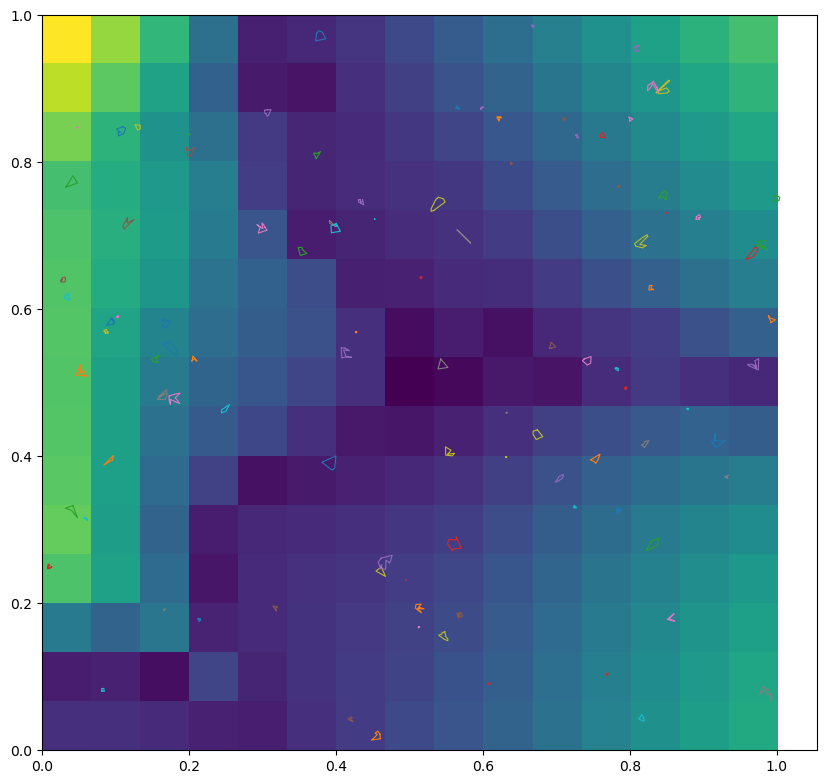

In [72]:
# lets find the critic
critic = ktree.root.critic

# pass serilized queries from 0 to 1 in x and y
n = 15
x = torch.linspace(0, 1, n)
y = torch.linspace(0, 1, n)
xx, yy = torch.meshgrid(x, y)
queries = torch.stack((xx.flatten(), yy.flatten()), dim=1).to(device)
print(queries.shape)
# print(queries)

e = critic(queries)
F, z = e.max(dim=1)
# plot
plt.figure(figsize=(10, 10))
plt.imshow(F.cpu().reshape(n, n).detach().numpy(), extent=[0, 1, 0, 1])
# also plot
for i, polygon in enumerate(polygons):
    plot_polygon(polygon)
# also plot random_queries
labels = torch.tensor(flags)
plt.scatter(random_queries[:, 0].cpu(), random_queries[:, 1].cpu(), c=labels, s=10)
plt.colorbar()
plt.show()